**Proof of Concept - Exploratory Analysis**

The skin temperature difference between different workout sets will be analyzed. For the purpose of this experiment, images will be the form of media because it allows images be captured from both built-in camera and FLIR camera. This should allow image alignment without confounding temperature.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from PIL import Image
import imutils

Note that Pictures 311, 311-Visual are rotated 90 degrees clockwise.

Note that Picture 889 seems to be uncalibrated

Use pandas to create a data structure containing these image filenames or image arrays.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/MyDrive/Stony Brook/Graduate Program/Project - CSE523"

Mounted at /content/drive
/content/drive/MyDrive/Stony Brook/Graduate Program/Project - CSE523


In [4]:
dir = "Media/"
md = pd.read_csv(dir + "media_metadata.txt", header=None,  names=["filename", "min_temp", "max_temp"])

# /content/drive/MyDrive/Stony Brook/Graduate Program/Project - CSE523/Media/media_metadata.txt

print(md.head())

imgs = []
for name in md.filename:
    img = cv2.imread(dir + name)

    if name[-7:-4] == "311":
        img = cv2.flip(img,1)

    if img.shape != (1440, 1080, 3):
        imgs.append(np.transpose(img, (1, 0, 2)))
    else:
        imgs.append(img)

print(imgs[0][0])
print(md.shape)

print(imgs[2].shape, imgs[1].shape, imgs[0].shape)

                       filename  min_temp  max_temp
0  FLIR_20220906_102026_232.jpg      25.1      32.9
1  FLIR_20220906_102246_263.jpg      24.7      32.5
2  FLIR_20220906_102427_311.jpg      24.6      33.0
3  FLIR_20220906_102738_798.jpg      24.3      32.7
4  FLIR_20220906_102815_889.jpg      23.9      33.7
[[ 28   0  20]
 [ 91  19  65]
 [137  12  81]
 ...
 [139 244 247]
 [139 243 248]
 [139 243 248]]
(8, 3)
(1440, 1080, 3) (1440, 1080, 3) (1440, 1080, 3)


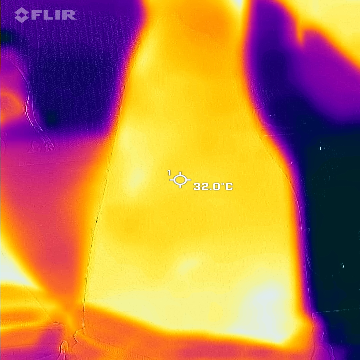

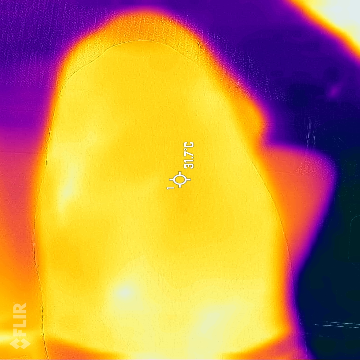

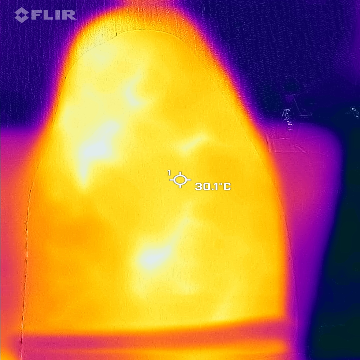

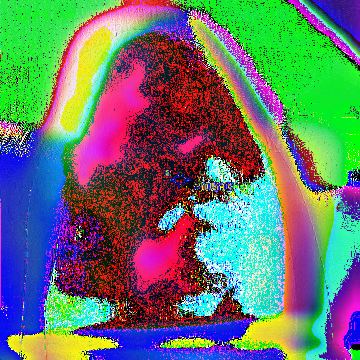

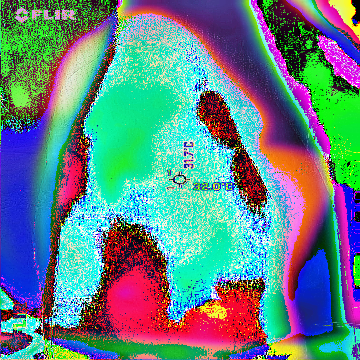

In [5]:
image = cv2.resize(imgs[0], (imgs[0].shape[0]//4, imgs[0].shape[1]//3))
cv2_imshow(image)

image = cv2.resize(imgs[2], (imgs[0].shape[0]//4, imgs[0].shape[1]//3))
cv2_imshow(image)

image = cv2.resize(imgs[7], (imgs[0].shape[0]//4, imgs[0].shape[1]//3))
cv2_imshow(image)

image = cv2.resize(imgs[7] - imgs[4], (imgs[0].shape[0]//4, imgs[0].shape[1]//3))
cv2_imshow(image)

image = cv2.resize(imgs[2] - imgs[1], (imgs[0].shape[0]//4, imgs[0].shape[1]//3))
cv2_imshow(image)

https://arxiv.org/abs/2012.05582 
Image matching and scaling

Obviously the images need scaling

In [6]:
# https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/ 

maxFeatures = 500
keepPercent = 1
debug = True

image = cv2.flip(np.transpose(cv2.imread(dir + md.filename[2][:-4] + "-Visual.jpeg"), (1, 0, 2)), 0) # imgs[2] #
template = cv2.imread(dir + md.filename[7][:-4] + "-Visual.jpeg") # imgs[7] # 
print(dir + md.filename[2][:-4] + "-Visual.jpg")
# cv2_imshow(image)
imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(maxFeatures)
(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
# match the features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)
matches = matcher.match(descsA, descsB, None)

# sort the matches by their distance (the smaller the distance,
# the "more similar" the features are)
matches = sorted(matches, key=lambda x:x.distance)
# keep only the top matches
keep = int(len(matches) * keepPercent)
matches = matches[:keep]
# check to see if we should visualize the matched keypoints
if debug:
    matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
      matches, None)
    matchedVis = imutils.resize(matchedVis, width=1000)
    cv2_imshow(matchedVis)
    cv2.waitKey(0)

# allocate memory for the keypoints (x, y)-coordinates from the
# top matches -- we'll use these coordinates to compute our
# homography matrix
ptsA = np.zeros((len(matches), 2), dtype="float")
ptsB = np.zeros((len(matches), 2), dtype="float")
# loop over the top matches
for (i, m) in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

# compute the homography matrix between the two sets of matched
# points
(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
# use the homography matrix to align the images
(h, w) = template.shape[:2]
aligned = cv2.warpPerspective(image, H, (w, h))
# return the aligned image
cv2_imshow(image)
cv2_imshow(template)
cv2_imshow(aligned)

Output hidden; open in https://colab.research.google.com to view.

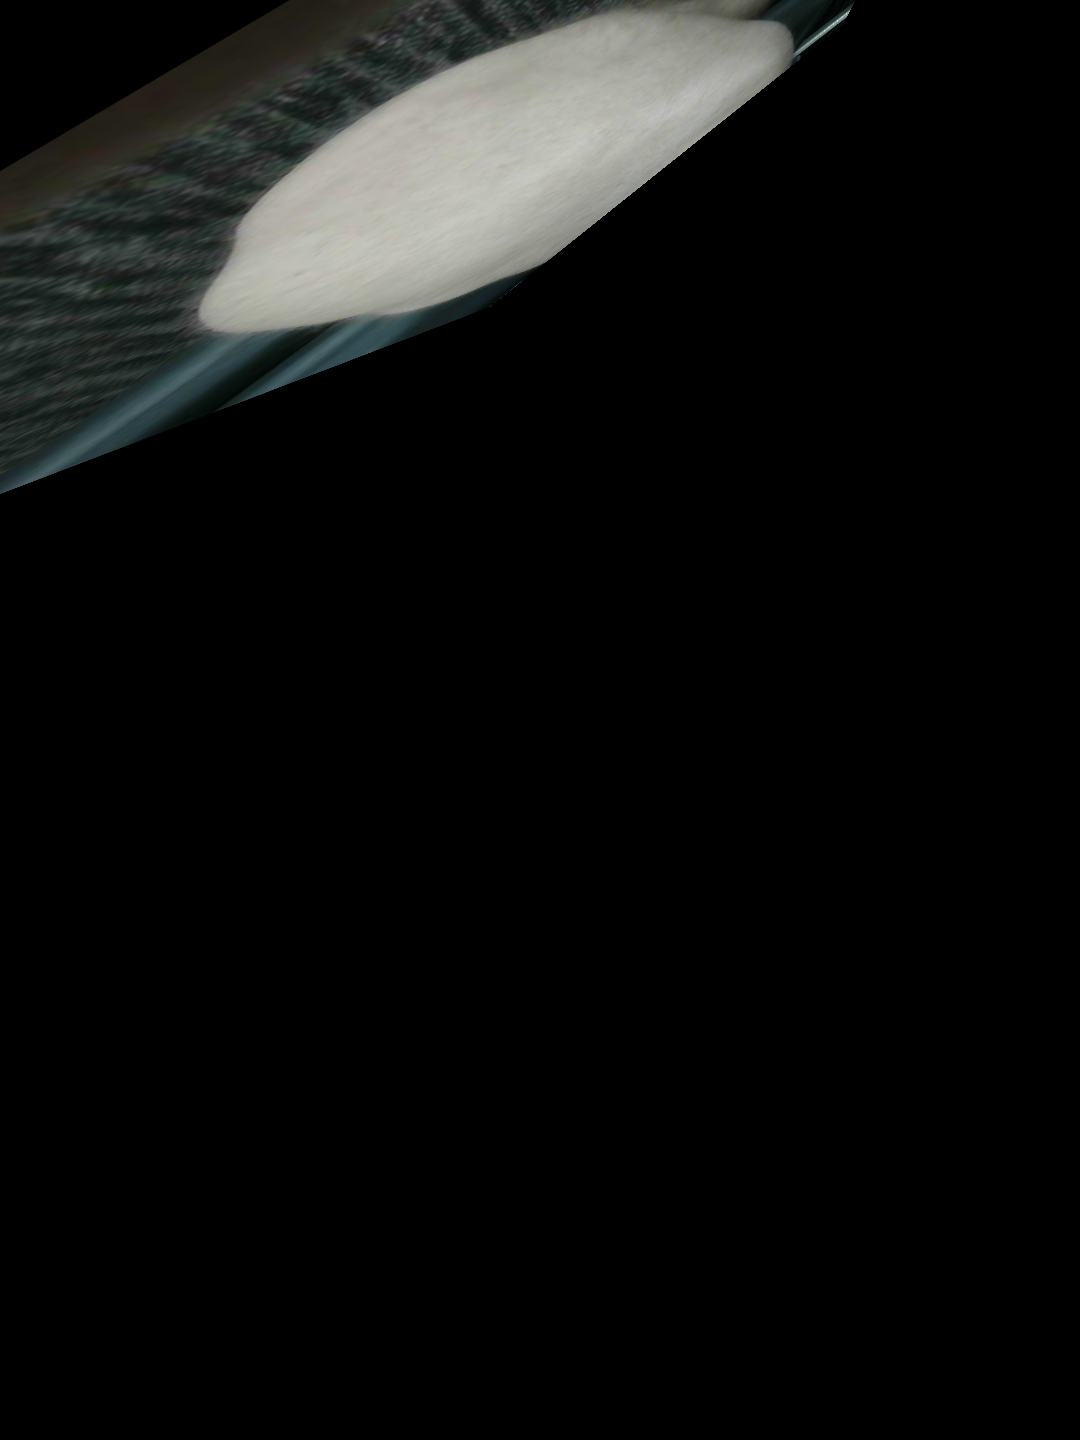

In [7]:
# https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/ 

from __future__ import print_function
import cv2
import numpy as np
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
def alignImages(im1, im2):
  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
  # Sort matches by score
  # matches.sort(key=lambda x: x.distance, reverse=False)
  matches = sorted(matches, key=lambda x:x.distance)
  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
  return im1Reg, h

im1Reg, h = alignImages(image, template)
cv2_imshow(im1Reg)

# alignedImg = ndi.affine_transform(img, mat_identity)

Since this is just a proof of concept, and not the final product, let's just manually align them since the image feature matching failed twice.

[[  1.   0.   0.]
 [  0.   1. -50.]
 [  0.   0.   1.]]


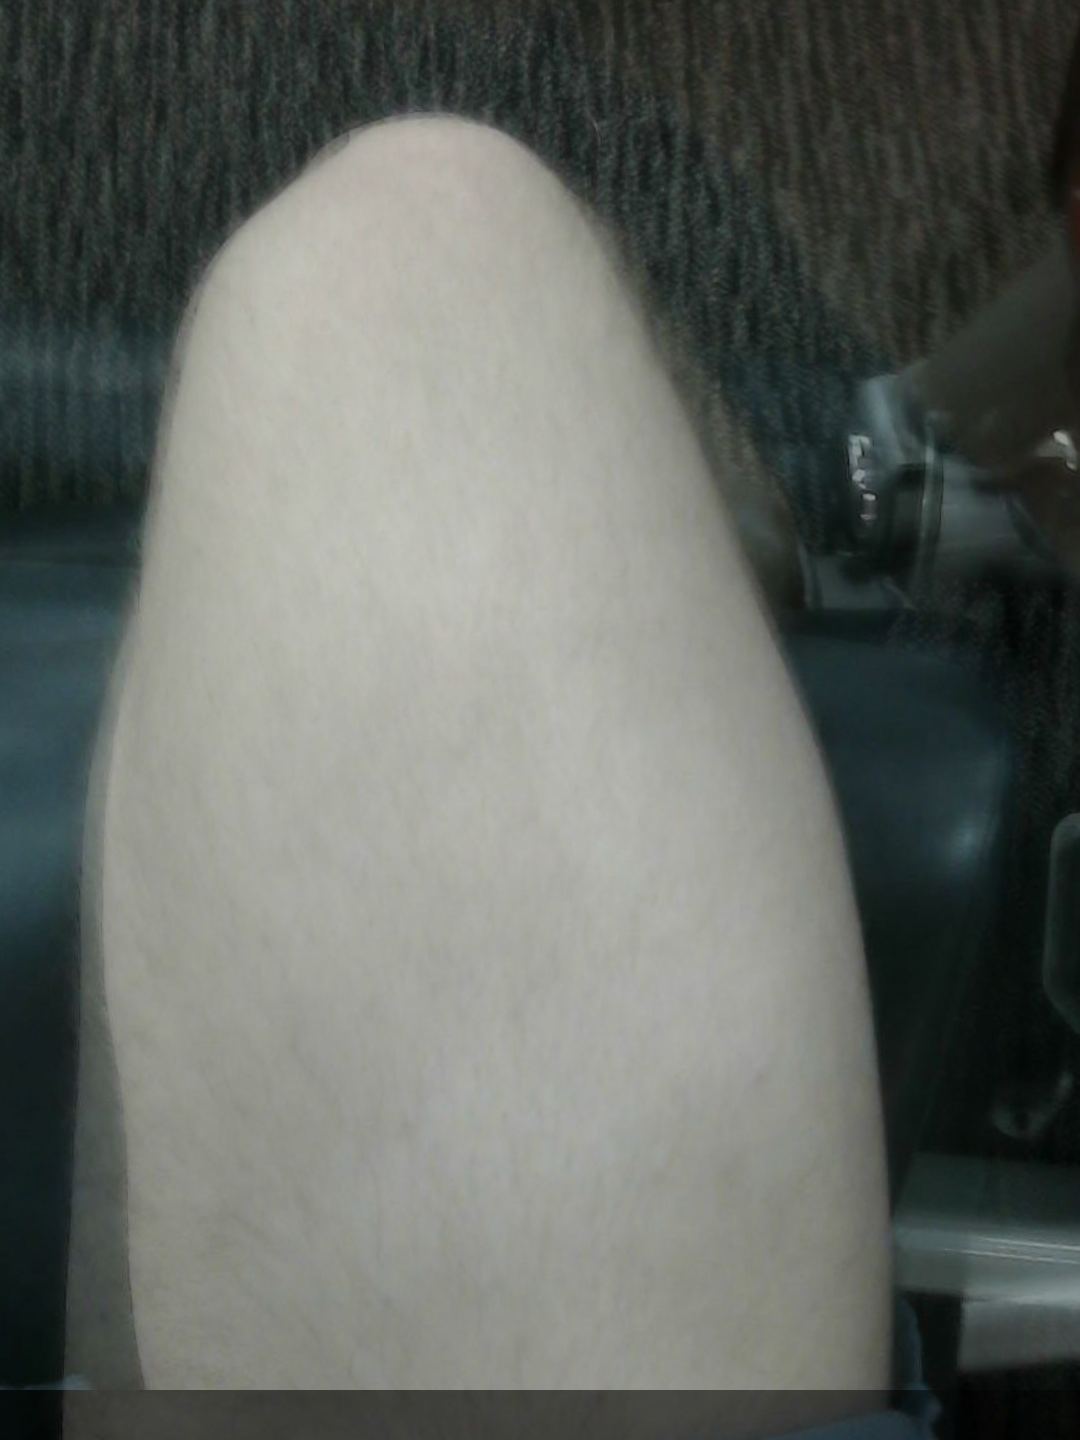

In [8]:
# h = np.array([
#      [0,0,0],
#      [0,0,0],
#      [0,0,1]
# ])

h = np.array([[ 1,  0, 0],[0,  1,  -50],[ 0,  0.0,  1]])

print(h)
aligned = cv2.warpPerspective(image, h, (image.shape[1], image.shape[0]))
# cv2_imshow(image)
# cv2_imshow(template)

dst = cv2.addWeighted(aligned,0.5,template,0.5,0)
cv2_imshow(dst)

In [9]:
# Apply transformation on heat image
aligned_heat = cv2.warpPerspective(imgs[2], h, (imgs[2].shape[1], imgs[2].shape[0]))
template_heat = imgs[7]

cv2_imshow(template_heat-aligned_heat)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
firstImageIndex = 2
secondImageIndex = 7

# Apply transformation on heat image
aligned_heat = cv2.warpPerspective(imgs[firstImageIndex], h, (imgs[firstImageIndex].shape[1], imgs[firstImageIndex].shape[0]))
template_heat = imgs[secondImageIndex]

# Apply temperature scale normalization
min_aligned_heat = md.min_temp[firstImageIndex]
max_aligned_heat = md.max_temp[firstImageIndex]

min_template_heat = md.min_temp[secondImageIndex]
max_template_heat = md.max_temp[secondImageIndex]

overall_min = min_aligned_heat if min_aligned_heat < min_template_heat else min_template_heat
overall_max = max_aligned_heat if max_aligned_heat > max_template_heat else max_template_heat

aligned_heat = aligned_heat * (max_aligned_heat - min_aligned_heat) / (overall_max - overall_min) + (min_aligned_heat - overall_min)/(overall_max - overall_min)
template_heat = template_heat * (max_template_heat - min_template_heat) / (overall_max - overall_min) + (min_template_heat - overall_min)/(overall_max - overall_min)

dif = template_heat-aligned_heat
normalized_dif = (dif - np.amin(dif)) * (255/np.amax(dif))

cv2_imshow(normalized_dif)

Output hidden; open in https://colab.research.google.com to view.